https://www.tensorflow.org/tutorials/images/classification?hl=fr

In [1]:
pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7395 sha256=ad150469f0e575a14f26ddfb2f288c5ef862d13a6595a84f3e52b0603e1bed9f
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [2]:
# Basic modules
import numpy as np
import pandas as pd
import os
import time
import random
import GPUtil
from glob import glob

# Plotting and graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Add, DepthwiseConv2D,Conv2D, MaxPooling2D, Flatten, Rescaling, ZeroPadding2D, Dense, Input, InputLayer, GlobalAveragePooling2D ,Activation, BatchNormalization, AveragePooling2D, add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50



In [3]:
print("Num GPUS Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS Available:  1


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU Device not found')
print('Found GPU : {}'.format(device_name))

Found GPU : /device:GPU:0


In [5]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1938632308440222528
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14410383360
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 185353382368981493
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Blood cells images come from Kaggle (https://www.kaggle.com/datasets/paultimothymooney/blood-cells) and are already augmented

In [7]:
# Define the work folder drive/u/0/shared-with-me
os.chdir("/content/drive/My Drive/Colab Notebooks/Blood cell type detection - DL project/blood cell images")

In [8]:
# Define the seed for reproducibility purpose
tf.random.set_seed(63)

In [9]:
# Define parameters used by the different models
batch_size = 32
epochs = 25

img_height = 320
img_width = 240


# **Image preparation**

### Creation of the different datasets (train, validation and test)

In [10]:
learn_dataset, test_dataset = keras.utils.image_dataset_from_directory('dataset1',
                                                                 image_size=(img_height, img_width),
                                                                 batch_size=batch_size,
                                                                 label_mode="int",
                                                                 validation_split=0.2,
                                                                 subset="both",
                                                                 shuffle=True,
                                                                 seed=63)

Found 12507 files belonging to 4 classes.
Using 10006 files for training.
Using 2501 files for validation.


In [11]:
# Split dataset in train and validation set
num_elements = len(learn_dataset)
train_size = int(0.8 * num_elements)
val_dataset = learn_dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = learn_dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

In [12]:
# Check length of the 3 datasets (number of batches of 32)
len(train_dataset), len(val_dataset), len(test_dataset)

(250, 63, 79)

In [13]:
# Get class names and number
class_names = learn_dataset.class_names
num_classes=len(class_names)

print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


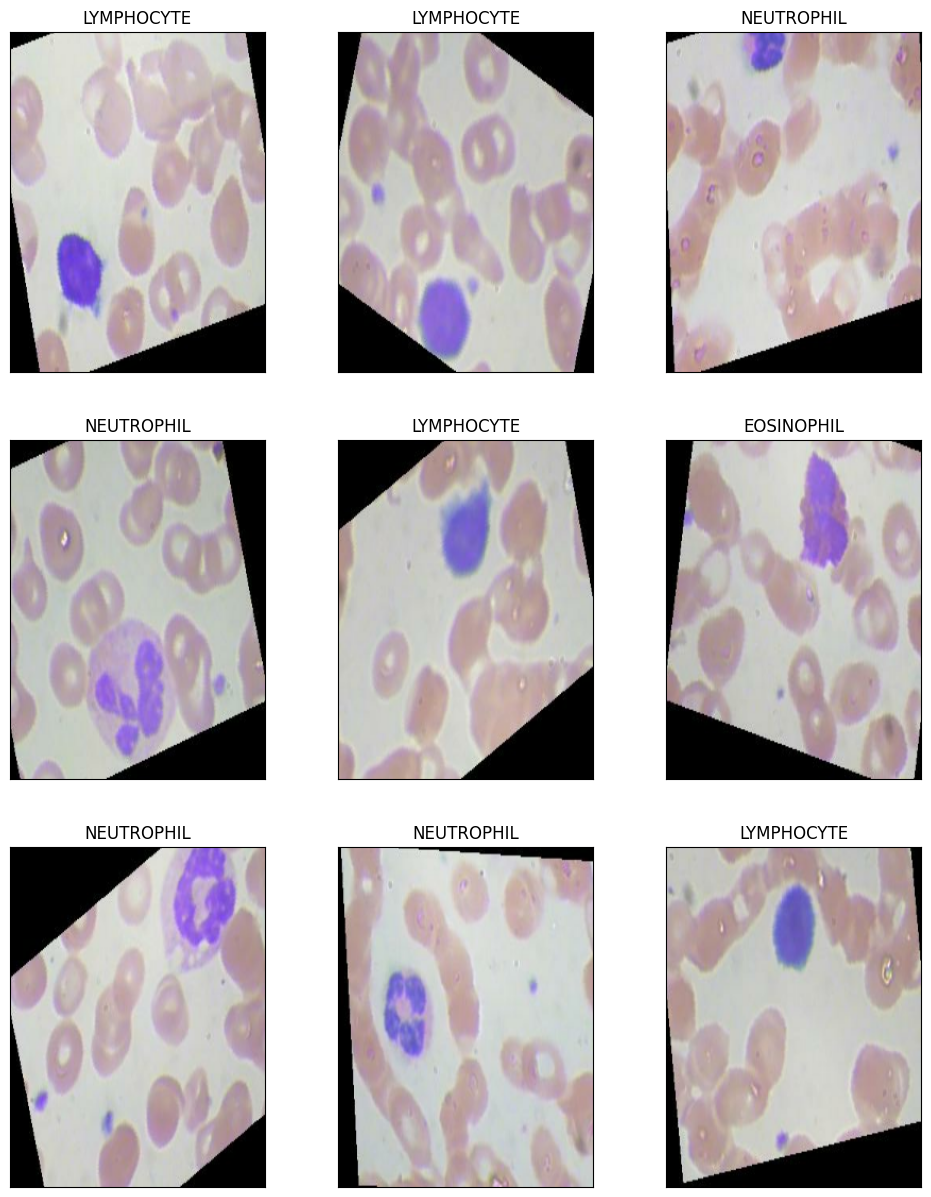

In [14]:
# Plot 9 images from the dataset as examples
fig, ax = plt.subplots(3, 3, figsize=(12,15))
ax = ax.flat
for images, labels in learn_dataset.take(1):
  for i in range(9):
    ax[i].set_title(class_names[labels[i].numpy()])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(images[i].numpy().astype("uint8"))
plt.savefig("Examples.png", dpi=300)

In [15]:
# Check format
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

Train data: (32, 320, 240, 3)
Train labels: (32,)


In [16]:
for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

Validation data: (32, 320, 240, 3)
Validation labels: (32,)


In [17]:
for image_batch, labels_batch in test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Test data: (32, 320, 240, 3)
Test labels: (32,)


# **Models**

In [18]:
# Create a lab-book to track the different experiments
lab_book = {}

In [19]:
#Create a callback to stop fit step before the end if the monitor is reached
earlystopping = EarlyStopping(monitor='val_accuracy',mode = 'max', patience = 5, verbose = 1, restore_best_weights=True)

## **Custom CNN model**
Based of "[A Novel Architecture to Classify Histopathology Images Using Convolutional Neural Networks](https://www.mdpi.com/2076-3417/10/8/2929)"

Based on the obtained results, two main points are recommended:
*    Try **different activation functions** and to fully analyze their impact other than choosing the ReLU activation function as a default.
*    Place the **normalization layer before the activation** function

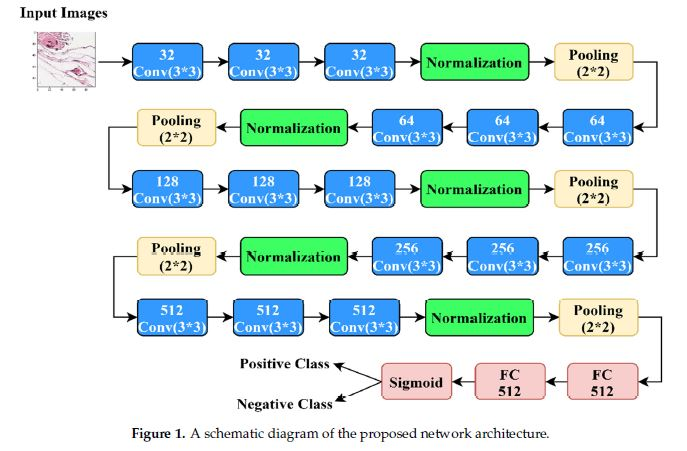

### Model 1
* No drop out layers in classifier block
* Activation = eLu
* Optimizer = ADAM

In [21]:
custom_cnn1 = Sequential()

#Input
custom_cnn1.add(Input(shape=(img_height, img_width, 3)))

#Rescaling
custom_cnn1.add(Rescaling(1./255))

#First convolutionnal block
custom_cnn1.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn1.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn1.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn1.add(BatchNormalization())
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(MaxPooling2D(pool_size = 2))

#Second convolutionnal block
custom_cnn1.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn1.add(BatchNormalization())
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(MaxPooling2D(pool_size = 3))

#Third convolutionnal block
custom_cnn1.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn1.add(BatchNormalization())
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(MaxPooling2D(pool_size = 3))

#Fourth convolutionnal block
custom_cnn1.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn1.add(BatchNormalization())
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(MaxPooling2D(pool_size = 3))

#Fifth convolutionnal block
custom_cnn1.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn1.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn1.add(BatchNormalization())
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(MaxPooling2D(pool_size = 2))

#Flatten block
custom_cnn1.add(Flatten())

#Classifier block without dropout
custom_cnn1.add(Dense(512))
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(Dense(512))
custom_cnn1.add(Activation('elu'))
custom_cnn1.add(Dense(num_classes, activation = 'softmax'))

In [22]:
custom_cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 320, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 320, 240, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 240, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 320, 240, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 320, 240, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 320, 240, 32)      0         
                                                        

In [23]:
# Compile the model with adam optimizer
name='model_1'
custom_cnn1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Defining specific Model Checkpoint (we will use already defined EarlyStopping "earlystopping" )
checkpoint = ModelCheckpoint(filepath='chkpt_model_1', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [28]:
# Train the model
custom_cnn1.fit(train_dataset, validation_data=val_dataset,
          epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 1.0576 - accuracy: 0.5266
Epoch 1: val_accuracy did not improve from 0.48205
250/250 [==============================] - 92s 367ms/step - loss: 1.0576 - accuracy: 0.5266 - val_loss: 1.5066 - val_accuracy: 0.3275
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.9318 - accuracy: 0.5855
Epoch 2: val_accuracy did not improve from 0.48205
250/250 [==============================] - 92s 369ms/step - loss: 0.9318 - accuracy: 0.5855 - val_loss: 1.4652 - val_accuracy: 0.3968
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.8740 - accuracy: 0.6133
Epoch 3: val_accuracy did not improve from 0.48205
250/250 [==============================] - 92s 368ms/step - loss: 0.8740 - accuracy: 0.6133 - val_loss: 7.7336 - val_accuracy: 0.3410
Epoch 4/25
250/250 [==============================] - ETA: 0s - loss: 0.8515 - accuracy: 0.6258
Epoch 4: val_accuracy did not improve from 0.48205
250/250 [=

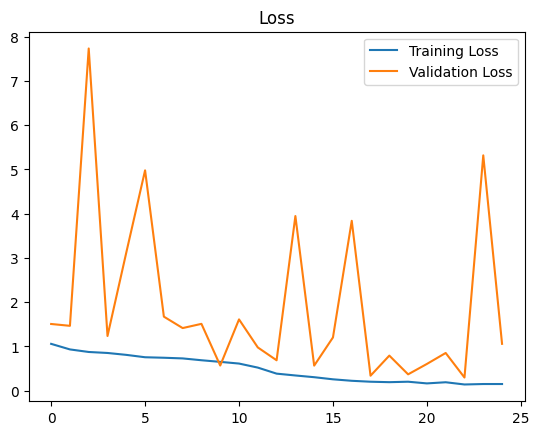

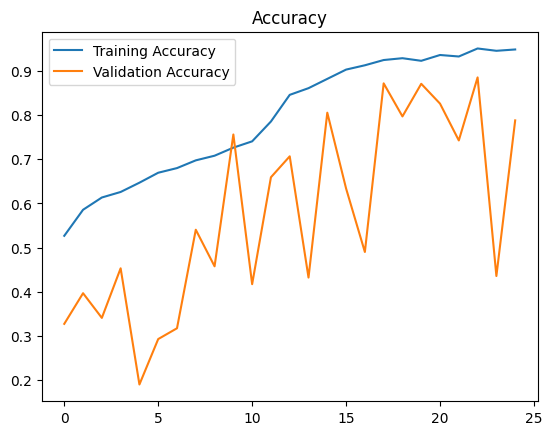

In [30]:
history_cnn1 = custom_cnn1.history.history

train_loss = history_cnn1['loss']
val_loss = history_cnn1['val_loss']
train_acc = history_cnn1['accuracy']
val_acc = history_cnn1['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [31]:
# Write lab-book
train_accuracy = custom_cnn1.evaluate(train_dataset)[1]
val_accuracy = custom_cnn1.evaluate(val_dataset)[1]
test_accuracy = custom_cnn1.evaluate(test_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 86s 1s/step - loss: 1.0545 - accuracy: 0.7917


In [32]:
# Save model
custom_cnn1.save("model_1.keras")

--------------------
### Model 2
* No drop out layers in classifier block
* Activation = eLu
* Optimizer = RMSProp


In [33]:
custom_cnn2 = Sequential()

custom_cnn2.add(Input(shape=(img_height, img_width, 3)))

#Rescaling
custom_cnn2.add(Rescaling(1./255))

#First convolutionnal block
custom_cnn2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn2.add(BatchNormalization())
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(MaxPooling2D(pool_size = 2))

#Second convolutionnal block
custom_cnn2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn2.add(BatchNormalization())
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(MaxPooling2D(pool_size = 3))

#Third convolutionnal block
custom_cnn2.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn2.add(BatchNormalization())
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(MaxPooling2D(pool_size = 3))

#Fourth convolutionnal block
custom_cnn2.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn2.add(BatchNormalization())
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(MaxPooling2D(pool_size = 3))

#Fifth convolutionnal block
custom_cnn2.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn2.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn2.add(BatchNormalization())
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(MaxPooling2D(pool_size = 2))

#Flatten block
custom_cnn2.add(Flatten())

#Classifier block without dropout
custom_cnn2.add(Dense(512))
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(Dense(512))
custom_cnn2.add(Activation('elu'))
custom_cnn2.add(Dense(num_classes, activation = 'softmax'))


In [34]:
# Compile the model with rmsprop optimizer
name='model_2'
custom_cnn2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_2', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [36]:
# Train the model
custom_cnn2.fit(train_dataset, validation_data=val_dataset,
          epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 1.9287 - accuracy: 0.3131
Epoch 1: val_accuracy improved from -inf to 0.44118, saving model to chkpt_model_2
250/250 [==============================] - 99s 382ms/step - loss: 1.9287 - accuracy: 0.3131 - val_loss: 1.1504 - val_accuracy: 0.4412
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.5254
Epoch 2: val_accuracy did not improve from 0.44118
250/250 [==============================] - 92s 368ms/step - loss: 1.0037 - accuracy: 0.5254 - val_loss: 2.7640 - val_accuracy: 0.2537
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.8536 - accuracy: 0.6036
Epoch 3: val_accuracy did not improve from 0.44118
250/250 [==============================] - 91s 365ms/step - loss: 0.8536 - accuracy: 0.6036 - val_loss: 2.0518 - val_accuracy: 0.3071
Epoch 4/25
250/250 [==============================] - ETA: 0s - loss: 0.7773 - accuracy: 0.6399
Epoch 4: val_accuracy improve

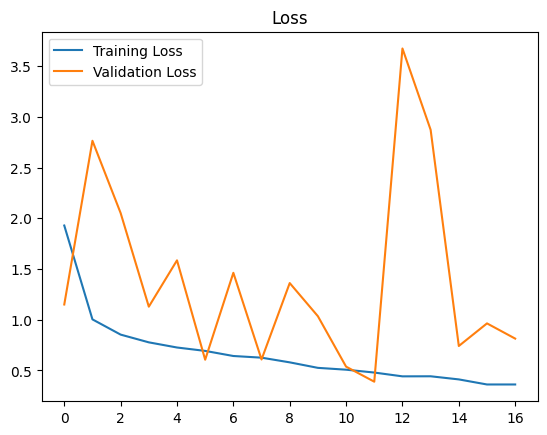

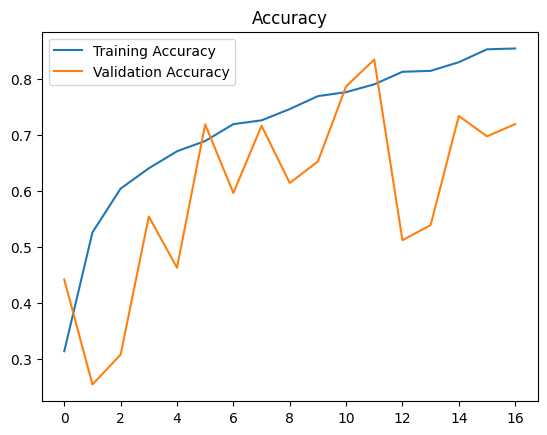

In [37]:
history_cnn2 = custom_cnn2.history.history

train_loss = history_cnn2['loss']
val_loss = history_cnn2['val_loss']
train_acc = history_cnn2['accuracy']
val_acc = history_cnn2['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [38]:
# Write lab-book
train_accuracy = custom_cnn2.evaluate(train_dataset)[1]
val_accuracy = custom_cnn2.evaluate(val_dataset)[1]
test_accuracy = custom_cnn2.evaluate(test_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 7s 94ms/step - loss: 0.3921 - accuracy: 0.8337


In [39]:
# Save model
custom_cnn2.save("model_2.keras")

### Model 3
* No drop out layers in classifier block
* Activation = eLu
* Optimizer = SGD

In [40]:
# Compile the model with SGD optimizer + ELU
name='model_3'

custom_cnn1.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_3', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [42]:
# Train the model
custom_cnn1.fit(train_dataset, validation_data=val_dataset,
          epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9643
Epoch 1: val_accuracy improved from -inf to 0.94118, saving model to chkpt_model_3
250/250 [==============================] - 98s 382ms/step - loss: 0.1023 - accuracy: 0.9643 - val_loss: 0.1657 - val_accuracy: 0.9412
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9709
Epoch 2: val_accuracy did not improve from 0.94118
250/250 [==============================] - 92s 368ms/step - loss: 0.0807 - accuracy: 0.9709 - val_loss: 7.7541 - val_accuracy: 0.4801
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9731
Epoch 3: val_accuracy did not improve from 0.94118
250/250 [==============================] - 92s 366ms/step - loss: 0.0743 - accuracy: 0.9731 - val_loss: 2.1823 - val_accuracy: 0.7612
Epoch 4/25
250/250 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9759
Epoch 4: val_accuracy improve

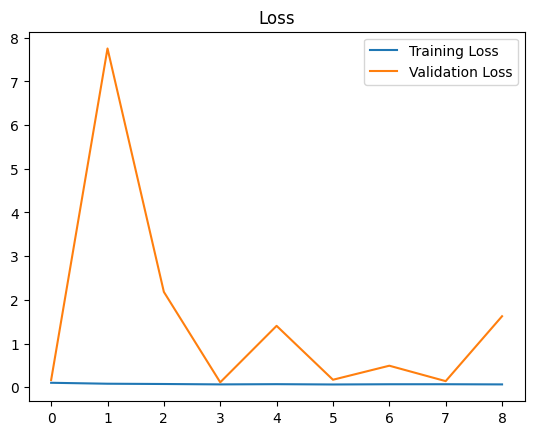

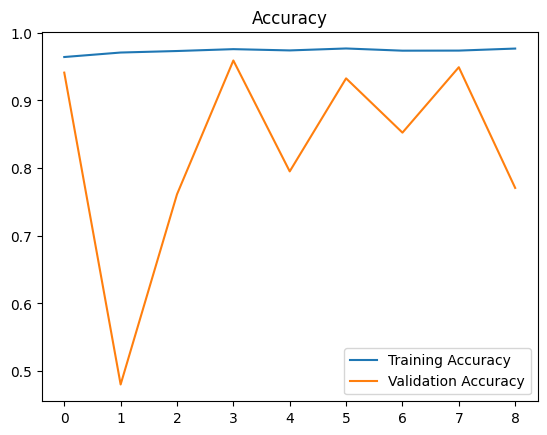

In [43]:
history_cnn3 = custom_cnn1.history.history

train_loss = history_cnn3['loss']
val_loss = history_cnn3['val_loss']
train_acc = history_cnn3['accuracy']
val_acc = history_cnn3['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [44]:
# Write lab-book
train_accuracy = custom_cnn1.evaluate(train_dataset)[1]
val_accuracy = custom_cnn1.evaluate(val_dataset)[1]
test_accuracy = custom_cnn1.evaluate(test_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 7s 94ms/step - loss: 0.1156 - accuracy: 0.9596


In [45]:
# Save model
custom_cnn1.save("model_3.keras")

### Model 4
* 2 drop out layers in classifier block
* Activation = eLu
* Optimizer = SGD

In [46]:
name='model_4'

custom_cnn4 = Sequential()

custom_cnn4.add(Input(shape=(img_height, img_width, 3)))

#Rescaling
custom_cnn4.add(Rescaling(1./255))

#First convolutionnal block
custom_cnn4.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn4.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn4.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides=1))
custom_cnn4.add(BatchNormalization())
custom_cnn4.add(Activation('elu'))
custom_cnn4.add(MaxPooling2D(pool_size = 2))

#Second convolutionnal block
custom_cnn4.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
custom_cnn4.add(BatchNormalization())
custom_cnn4.add(Activation('elu'))
custom_cnn4.add(MaxPooling2D(pool_size = 3))

#Third convolutionnal block
custom_cnn4.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
custom_cnn4.add(BatchNormalization())
custom_cnn4.add(Activation('elu'))
custom_cnn4.add(MaxPooling2D(pool_size = 3))

#Fourth convolutionnal block
custom_cnn4.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
custom_cnn4.add(BatchNormalization())
custom_cnn4.add(Activation('elu'))
custom_cnn4.add(MaxPooling2D(pool_size = 3))

#Fifth convolutionnal block
custom_cnn4.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn4.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same'))
custom_cnn4.add(BatchNormalization())
custom_cnn4.add(Activation('elu'))
custom_cnn4.add(MaxPooling2D(pool_size = 2))

#Flatten block
custom_cnn4.add(Flatten())

#Classifier block with dropout
custom_cnn4.add(Dense(512, activation='elu'))
custom_cnn4.add(Dropout(0.3))
custom_cnn4.add(Dense(512, activation = 'elu'))
custom_cnn4.add(Dropout(0.3))
custom_cnn4.add(Dense(num_classes, activation = 'softmax'))


In [47]:
custom_cnn4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 320, 240, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 320, 240, 32)      896       
                                                                 
 conv2d_31 (Conv2D)          (None, 320, 240, 32)      9248      
                                                                 
 conv2d_32 (Conv2D)          (None, 320, 240, 32)      9248      
                                                                 
 batch_normalization_10 (Ba  (None, 320, 240, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_14 (Activation)  (None, 320, 240, 32)      0         
                                                      

In [48]:
# Compile the model with SGD optimizer
custom_cnn4.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_4', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [50]:
# Train the model
custom_cnn4.fit(train_dataset, validation_data=val_dataset,
          epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 1.3533 - accuracy: 0.4818
Epoch 1: val_accuracy improved from -inf to 0.25523, saving model to chkpt_model_4
250/250 [==============================] - 98s 379ms/step - loss: 1.3533 - accuracy: 0.4818 - val_loss: 4.7312 - val_accuracy: 0.2552
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.7481
Epoch 2: val_accuracy improved from 0.25523 to 0.72881, saving model to chkpt_model_4
250/250 [==============================] - 95s 378ms/step - loss: 0.5977 - accuracy: 0.7481 - val_loss: 0.6365 - val_accuracy: 0.7288
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.8356
Epoch 3: val_accuracy improved from 0.72881 to 0.75922, saving model to chkpt_model_4
250/250 [==============================] - 95s 379ms/step - loss: 0.3986 - accuracy: 0.8356 - val_loss: 0.5769 - val_accuracy: 0.7592
Epoch 4/25
250/250 [==============================] - E

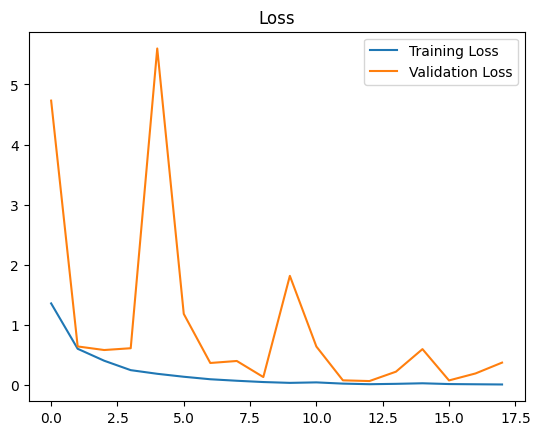

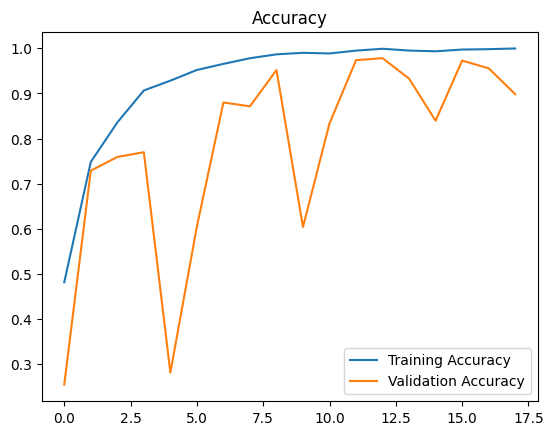

In [51]:
history_cnn4 = custom_cnn4.history.history

train_loss = history_cnn4['loss']
val_loss = history_cnn4['val_loss']
train_acc = history_cnn4['accuracy']
val_acc = history_cnn4['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [52]:
# Write lab-book
train_accuracy = custom_cnn4.evaluate(train_dataset)[1]
val_accuracy = custom_cnn4.evaluate(val_dataset)[1]
test_accuracy = custom_cnn4.evaluate(test_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 8s 99ms/step - loss: 0.0794 - accuracy: 0.9720


In [53]:
# Save model
custom_cnn4.save("model_4.keras")

## **ResNet architecture**

In [54]:
# Prepare data for ResNet50 input
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

train_dataset_resnet = train_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)
val_dataset_resnet = val_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)
test_dataset_resnet = test_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)

In [55]:
# Check format
for image_batch, labels_batch in train_dataset_resnet.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset_resnet.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset_resnet.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 320, 240, 3)
Train labels: (32,)
Validation data: (32, 320, 240, 3)
Validation labels: (32,)
Test data: (32, 320, 240, 3)
Test labels: (32,)


### Model 5 - Feature extraction with ResNet50

The ResNet50 model is used to extract features. To do this, the datasets must be transformed to meet the requirements of this model.

In [56]:
# Name the model
name = "model_5"

# Download the pretrained resnet model and save it as a layer
res_model = ResNet50(include_top=False,
                                    input_shape=(img_height, img_width, 3))

# Freeze all layers of base model
res_model.trainable = False

# Build model
model_resnet1 = keras.Sequential([res_model,
                            layers.GlobalAvgPool2D(),
                            layers.Dense(num_classes, activation="softmax")
                            ], name=name)

94765736/94765736 [==============================] - 1s 0us/step


In [57]:
# Compile model
model_resnet1.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])

In [58]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_5', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [59]:
# Fit model
history_5 = model_resnet1.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=epochs,
                        callbacks=[earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 1.8030 - accuracy: 0.4229
Epoch 1: val_accuracy improved from -inf to 0.61715, saving model to chkpt_model_5
250/250 [==============================] - 72s 272ms/step - loss: 1.8030 - accuracy: 0.4229 - val_loss: 0.9268 - val_accuracy: 0.6171
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 1.1047 - accuracy: 0.5820
Epoch 2: val_accuracy did not improve from 0.61715
250/250 [==============================] - 51s 202ms/step - loss: 1.1047 - accuracy: 0.5820 - val_loss: 0.9783 - val_accuracy: 0.5369
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.9198 - accuracy: 0.6403
Epoch 3: val_accuracy improved from 0.61715 to 0.73480, saving model to chkpt_model_5
250/250 [==============================] - 66s 262ms/step - loss: 0.9198 - accuracy: 0.6403 - val_loss: 0.7043 - val_accuracy: 0.7348
Epoch 4/25
250/250 [==============================] - ETA: 0s - loss: 0.8131 - accuracy: 0

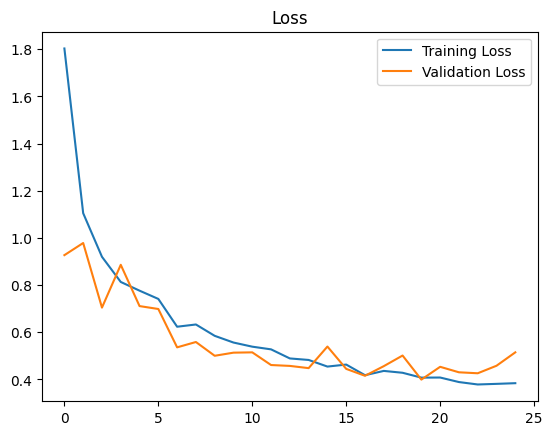

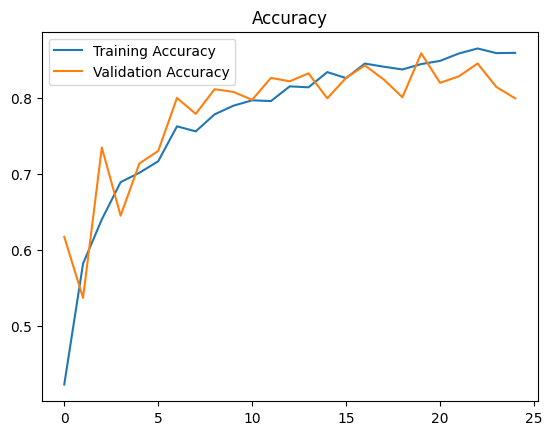

In [60]:
history_res1 = model_resnet1.history.history

train_loss = history_res1['loss']
val_loss = history_res1['val_loss']
train_acc = history_res1['accuracy']
val_acc = history_res1['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [61]:
# Write lab-book
train_accuracy = model_resnet1.evaluate(train_dataset_resnet)[1]
val_accuracy = model_resnet1.evaluate(val_dataset_resnet)[1]
test_accuracy = model_resnet1.evaluate(test_dataset_resnet)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 12s 150ms/step - loss: 0.3867 - accuracy: 0.8585


In [62]:
# Save model
model_resnet1.save("model_5.keras")

### Model 6 - Transfer learning with ResNet50 (partial training)
The same architecture as in previous one, but this time the ResNet50 base model is partially unfrozen. We ‘freeze’ all layers except for the last block of the ResNet50 that will be trained

In [63]:
# Name the model
name = "model_6"

# Freeze all layers of base model except the last block
for layer in res_model.layers[144:]:
      layer.trainable = True
# Check the freezed was done ok
for i, layer in enumerate(res_model.layers):
        print(i, layer.name, "-", layer.trainable)

0 input_4 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [64]:
# Build model integrating the classifier block created in custom_cnn model
model_resnet2 = keras.Sequential([res_model,
                                  layers.Flatten(),
                                  layers.BatchNormalization(),
                                  layers.Dense(512, activation='relu'), #change the activation function?
                                  layers.Dropout(0.3),
                                  layers.Dense(512, activation = 'relu'), #change the activation function?
                                  layers.Dropout(0.3),
                                  layers.Dense(num_classes, activation='softmax')],name=name)

In [65]:
# Compile model
model_resnet2.compile(loss='sparse_categorical_crossentropy',
                optimizer='sgd',
                metrics=["accuracy"])

In [66]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_6', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [67]:
# Fit model
history_6 = model_resnet2.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=30,
                        callbacks=[earlystopping, checkpoint])

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.9753 - accuracy: 0.6530
Epoch 1: val_accuracy improved from -inf to 0.86740, saving model to chkpt_model_6
250/250 [==============================] - 80s 304ms/step - loss: 0.9753 - accuracy: 0.6530 - val_loss: 0.3451 - val_accuracy: 0.8674
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9280
Epoch 2: val_accuracy improved from 0.86740 to 0.90578, saving model to chkpt_model_6
250/250 [==============================] - 75s 297ms/step - loss: 0.2026 - accuracy: 0.9280 - val_loss: 0.2605 - val_accuracy: 0.9058
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9674
Epoch 3: val_accuracy improved from 0.90578 to 0.91625, saving model to chkpt_model_6
250/250 [==============================] - 76s 301ms/step - loss: 0.0867 - accuracy: 0.9674 - val_loss: 0.2367 - val_accuracy: 0.9163
Epoch 4/30
250/250 [==============================] - E

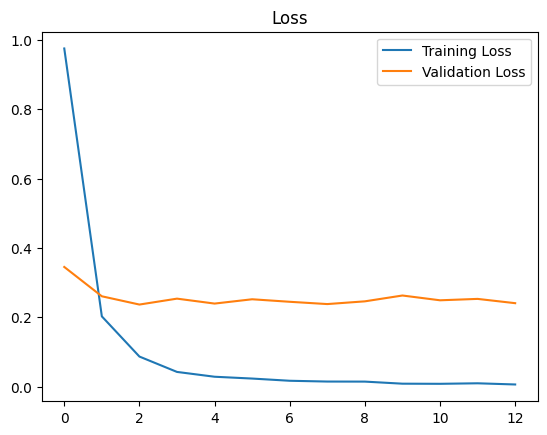

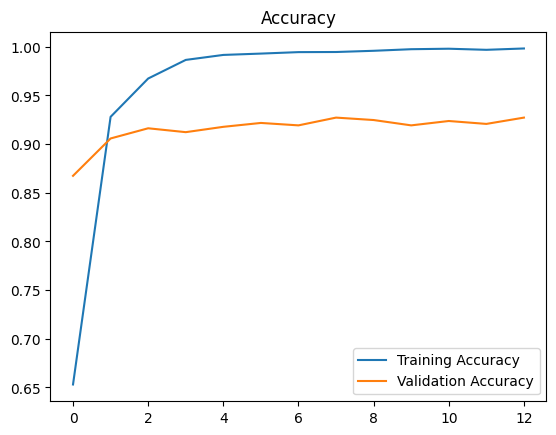

In [68]:
history_res2 = model_resnet2.history.history

train_loss = history_res2['loss']
val_loss = history_res2['val_loss']
train_acc = history_res2['accuracy']
val_acc = history_res2['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [69]:
# Write lab-book
train_accuracy = model_resnet2.evaluate(train_dataset_resnet)[1]
val_accuracy = model_resnet2.evaluate(val_dataset_resnet)[1]
test_accuracy = model_resnet2.evaluate(test_dataset_resnet)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 12s 155ms/step - loss: 0.2797 - accuracy: 0.9116


In [70]:
# Save model
model_resnet2.save("model_6.keras")

### Model 7 - Transfer learning with ResNet50 (full training)
The same architecture as in previous one, but this time the ResNet50 base model is **fully** unfrozen to be trained.

In [71]:
# Unfreeze all layers of base model
res_model.trainable = True

In [72]:
name = "model_7"

model_resnet3 = keras.Sequential([res_model,
                                  layers.Flatten(),
                                  layers.BatchNormalization(),
                                  layers.Dense(512, activation='relu'), #change the activation function?
                                  layers.Dropout(0.3),
                                  layers.Dense(512, activation = 'relu'), #change the activation function?
                                  layers.Dropout(0.3),
                                  layers.Dense(num_classes, activation='softmax')],name=name)

In [73]:
model_resnet3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 8, 2048)       23587712  
                                                                 
 flatten_4 (Flatten)         (None, 163840)            0         
                                                                 
 batch_normalization_16 (Ba  (None, 163840)            655360    
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 512)               83886592  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                           

In [74]:
# Compile model
model_resnet3.compile(loss='sparse_categorical_crossentropy',
                optimizer='sgd',
                metrics=["accuracy"])

In [75]:
# Creation of the checkpoint
checkpoint = ModelCheckpoint(filepath='chkpt_model_7', monitor="val_accuracy", mode="max", save_best_only = True, verbose=1)

In [76]:
# Fit model
history_7 = model_resnet3.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=epochs,
                        callbacks=[earlystopping, checkpoint])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 0.4761 - accuracy: 0.8253
Epoch 1: val_accuracy improved from -inf to 0.89083, saving model to chkpt_model_7
250/250 [==============================] - 181s 654ms/step - loss: 0.4761 - accuracy: 0.8253 - val_loss: 0.2863 - val_accuracy: 0.8908
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9736
Epoch 2: val_accuracy did not improve from 0.89083
250/250 [==============================] - 140s 559ms/step - loss: 0.0739 - accuracy: 0.9736 - val_loss: 0.3441 - val_accuracy: 0.8903
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9883
Epoch 3: val_accuracy improved from 0.89083 to 0.94417, saving model to chkpt_model_7
250/250 [==============================] - 161s 644ms/step - loss: 0.0380 - accuracy: 0.9883 - val_loss: 0.1527 - val_accuracy: 0.9442
Epoch 4/25
250/250 [==============================] - ETA: 0s - loss: 0.0144 - accuracy

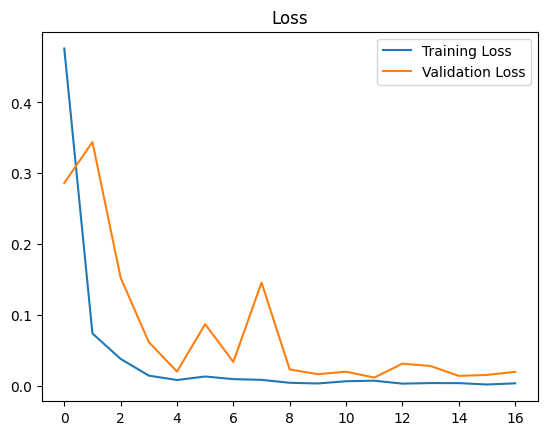

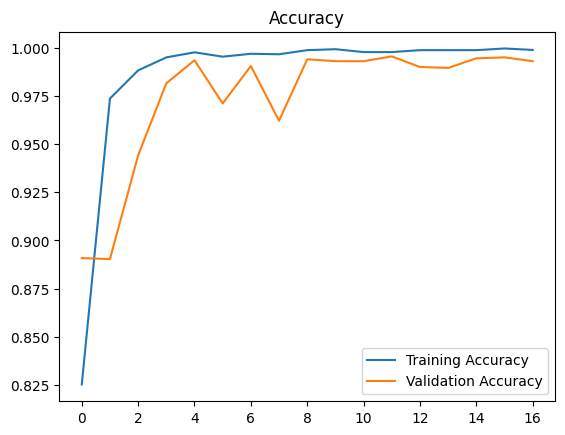

In [77]:
history_res3 = model_resnet3.history.history

train_loss = history_res3['loss']
val_loss = history_res3['val_loss']
train_acc = history_res3['accuracy']
val_acc = history_res3['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [78]:
# Write lab-book
train_accuracy = model_resnet3.evaluate(train_dataset_resnet)[1]
val_accuracy = model_resnet3.evaluate(val_dataset_resnet)[1]
test_accuracy = model_resnet3.evaluate(test_dataset_resnet)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "test_accuracy": test_accuracy}

79/79 [==============================] - 12s 146ms/step - loss: 0.0238 - accuracy: 0.9928


In [79]:
# Save model
model_resnet3.save("model_7.keras")

## Models comparison

In [80]:
# Compare accuracies of different models
df_acc = pd.DataFrame(lab_book).transpose()
df_acc

,train_accuracy,val_accuracy,test_accuracy
model_1,0.793750,0.783151,0.791683
model_2,0.847375,0.833001,0.833667
model_3,0.974000,0.959123,0.959616
model_4,0.999000,0.978564,0.972011
model_5,0.883000,0.861914,0.858457
model_6,0.999875,0.927218,0.911635
model_7,1.000000,0.995513,0.992803


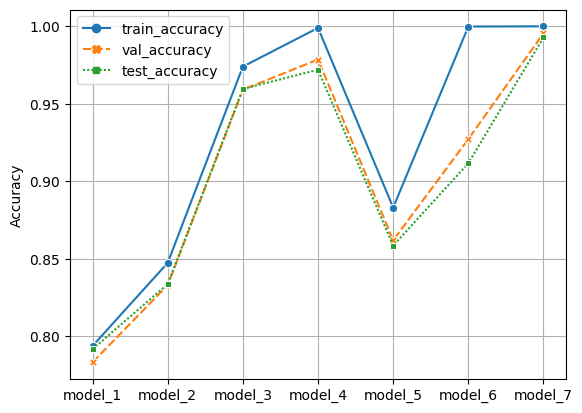

In [81]:
# Plot accuracies against models
sns.lineplot(data=df_acc, markers=True)
plt.grid()
plt.ylabel("Accuracy")
plt.savefig("Accuracy plot.png", dpi=300)
plt.show()